In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# actual_m = 10
# actual_c = 20

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
y = [2, 1, 2, 1, 7, 6, 7, 6, 12, 11, 12, 11]
y

[2, 1, 2, 1, 7, 6, 7, 6, 12, 11, 12, 11]

<Axes: >

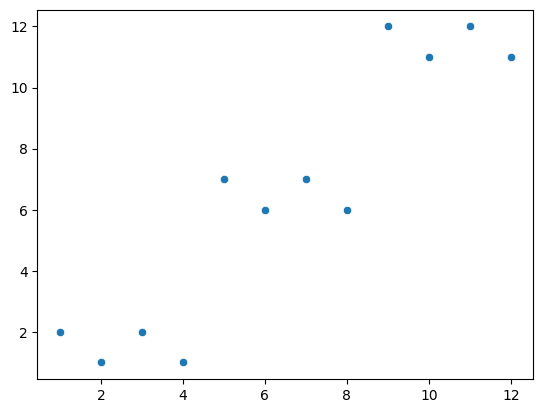

In [3]:
sns.scatterplot(x=x, y=y)

In [4]:
no_of_nodes = 3

In [5]:
N = len(x) // no_of_nodes
# N

In [6]:
# node_1_data = {"x": x[:N], "y": y[:4]}
# node_2_data = {"x": x[4:8], "y": y[4:8]}
# node_3_data = {"x": x[8:12], "y": y[8:12]}
node_data = []
for i in range(no_of_nodes):
    node_data.append({"x": x[i*N:(i+1)*N], "y": y[i*N:(i+1)*N]})
    node_data[-1]["y_mean"] = sum(node_data[-1]["y"])/len(node_data[-1]["y"])
node_data

[{'x': [1, 2, 3, 4], 'y': [2, 1, 2, 1], 'y_mean': 1.5},
 {'x': [5, 6, 7, 8], 'y': [7, 6, 7, 6], 'y_mean': 6.5},
 {'x': [9, 10, 11, 12], 'y': [12, 11, 12, 11], 'y_mean': 11.5}]

In [7]:
node_params = [ {"m": 0, "c": 0} for i in range(no_of_nodes)]
node_params

[{'m': 0, 'c': 0}, {'m': 0, 'c': 0}, {'m': 0, 'c': 0}]

In [8]:
iterations = 1000

In [9]:
L = 0.00001 # learning rate

In [10]:
def forward_node(node_id):
    params = node_params[node_id]
    x = node_data[node_id]["x"]
    return [params["m"] * i + params["c"] for i in x]

In [11]:
def loss_fn_node(node_id, y_pred):
    y = node_data[node_id]["y"]
    return (1 / N) * sum( (y[i] - y_pred[i]) ** 2 for i in range(N) )

In [12]:
def r2_score_node(node_id, y_pred):
    y = node_data[node_id]["y"]
    y_mean = node_data[node_id]["y_mean"]
    rss = sum( (y[i] - y_pred[i])**2 for i in range(N) )
    tss = sum( (y[i] - y_mean)**2 for i in range(N) )
    r2 = 1 - rss/tss 
    return r2

In [13]:
def gradient_m_node(node_id, y_pred):
    x = node_data[node_id]["x"]
    y = node_data[node_id]["y"]
    return (-2 / N) * sum( ( x[i] * (y[i] - y_pred[i]) ) for i in range(N) )

In [14]:
def gradient_c_node(node_id, y_pred):
    y = node_data[node_id]["y"]
    return (-2 / N) * sum( (y[i] - y_pred[i]) for i in range(N) )

In [15]:
doubly_stochastic_matrix_config = [
    [1/2, 1/4, 1/4],
    [1/4, 0, 3/4],
    [1/4, 3/4, 0]
]

In [16]:
# doubly_stochastic_matrix_config = [
#     [1/3, 1/3, 1/3],
#     [1/3, 1/3, 1/3],
#     [1/3, 1/3, 1/3]
# ]

In [17]:
# for i in range(iterations):
#     for node_id in range(no_of_nodes):
#         y_pred = forward_node(node_id)
#         loss = loss_fn_node(node_id, y_pred)
#         accuracy = r2_score_node(node_id, y_pred)
#         print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))
    
#         grad_m = gradient_m_node(node_id, y_pred)
#         grad_c = gradient_c_node(node_id, y_pred)
#         # print("gradient of m:", grad_m, "| graident of c:", grad_c)

#         params = node_params[node_id]
#         params['m'] = params['m'] - L * grad_m
#         params['c'] = params['c'] - L * grad_c
#         # print(params)
#         # print()

#     # comm and averaging
#     node_params_copy = node_params.copy()
#     for node_id in range(no_of_nodes):
#         doubly_st_mt = doubly_stochastic_matrix_config[node_id]
#         node_params[node_id]["m"] = sum( frac*node_params_copy[i]["m"] for i, frac in enumerate(doubly_st_mt) )
#         node_params[node_id]["c"] = sum( frac*node_params_copy[i]["c"] for i, frac in enumerate(doubly_st_mt) )

#     print(node_params)

In [18]:
steps_data = []
accuracy_data = [
    [] for i in range(no_of_nodes)
]

In [19]:
for i in range(1, iterations+1):
    gradients = []
    steps_data.append(i)
    for node_id in range(no_of_nodes):
        y_pred = forward_node(node_id)
        loss = loss_fn_node(node_id, y_pred)
        accuracy = r2_score_node(node_id, y_pred)
        accuracy_data[node_id].append(accuracy)
        # print("Node:", node_id, "| Loss:", round(loss, 6), "| Accuracy:", round(accuracy, 6))
    
        grad_m = gradient_m_node(node_id, y_pred)
        grad_c = gradient_c_node(node_id, y_pred)
        # print("gradient of m:", grad_m, "| graident of c:", grad_c)

        gradients.append({"m": grad_m, "c": grad_c})
        # print(params)
        # print()

    # comm and averaging
    for node_id in range(no_of_nodes):
        doubly_st_mt = doubly_stochastic_matrix_config[node_id]
        params = node_params[node_id]
        grad_m = sum( frac*gradients[i]["m"] for i, frac in enumerate(doubly_st_mt) )
        grad_c = sum( frac*gradients[i]["c"] for i, frac in enumerate(doubly_st_mt) )
        params['m'] = params['m'] - L * grad_m
        params['c'] = params['c'] - L * grad_c

    gradients = []
    # print(node_params)

In [30]:
data = {f'Node {i}': accuracy_data[i] for i in range(no_of_nodes)}
df = pd.DataFrame({"Iteration": steps_data, **data})
dfl = pd.melt(df, ["Iteration"], value_name="Accuracy", var_name="Node")

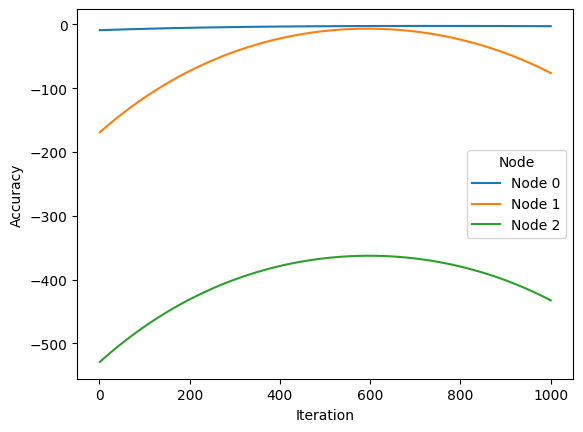

In [31]:
ax = sns.lineplot(data=dfl, x='Iteration', y='Accuracy', hue='Node')